### 1. Upload dataset (.dta)

In [1]:
use "https://github.com/worldbank/Stata-IE-Visual-Library/raw/develop/Library/Bar%20plots/Bar%20plot%20of%20multiple%20variables/data.dta", clear

### 2. Separate crop production var into two distinct rounds (i.e. baseline and midline)

In [2]:
qui foreach var of varlist 	w_Main_Paddy_Prod w_Wheat_Prod w_Spring_Winter_Potato_Prod w_Summer_Maize_Prod ///
                        w_Spring_Winter_Maize_Prod w_Summer_Potato_Prod w_Upland_Paddy_Prod w_Millet_Prod ///
                        w_Barley_Prod w_Mustard_Prod w_Beans_Prod w_Soybeans_Prod w_Lentil_Prod ///
                        w_Black_Gram_Prod w_Pea_Prod  {
                            gen bl_`var' = `var' if round == 1
                            gen ml_`var' = `var' if round == 2
                        }

### 3. Consolidate treatment assignment group from two rounds into one (``tmt-group``)

In [3]:
qui gen 	tmt_group = (treatment == 1 | treatment == 2)
qui replace tmt_group = 0 if tmt_group == .

### 4. Keeping only the mean of the crop production variables of concern, per treatment assignment

In [4]:
collapse bl_* ml_*, by(tmt_group)

### 5. Reshaping dataset to have crop variables in one column

For each value of `tmt_group`, we want to have the average be calculated across observations -- so we `reshape` to a long-format dataset, indexed by the new `crop` variable. This is a string with the name of the crop.

(e.g. from ``ml_w_Barley_Prod`` and ``bl_w_Barley_Prod``, ``w_Barley_Prod`` becomes the value of the `crop` variable.) 


End product: data with columns of 

    tmt_group
    crop
    bl_ 
    ml_

In [5]:
qui reshape long bl_ ml_, i(tmt_group) j(crop) str

### 6. Reshapiing dataset to have treatment group under one column

For each value of ``crop``, the code takes variable ``tmt_group`` create a new merged variable with ``bl_`` and ``ml_`` variables.

(e.g. Each ``bl_`` variable will now have two types, ``bl_0 `` and ``bl_1``, using values from ``tmt_group`` 1/0. )

End product: data with columns of:

    crop
    bl_0
    bl_1
    ml_0
    ml_1


In [6]:
qui reshape wide bl_ ml_, i(crop) j(tmt_group)

### 7. Sorting the data set in ascending order, by ``ml_`` variable, and keeping only the data with the largest 3 value

In [7]:
gsort -ml_1
qui keep if _n<4

### 8. Creating the variable of the order and var with added constant (this variables are used later for labelling bar plot value (y-axis location), rounding decimals of  ``_ml`` / ``_bl`` variables

In [8]:
qui gen xml_1 = _n
qui gen xml_0 = xml_1 +.2
qui gen xbl_1 = xml_1 +.4
qui gen xbl_0 = xml_1 +.6

qui foreach var of varlist bl_* ml_* {
	replace `var' = round(`var',.1)
	}

### 9. Cleaning the string variable (``crop``) values

In [9]:
qui replace crop = subinstr(crop, "_", " ",.) 
qui replace crop = subinstr(crop, "w", " ",.)

### 10. Creating a horizontal bar graph with cleaned data



. twoway bar bl_0 xbl_0, horizontal bcolor(edkblue) barwidth(.2) ||  bar ml_0 xml_0, horizontal bcolor(eltblue) barwidth(.2) ||  scatter xml_0 ml_0, mlabel(ml_0) mlabcolor(black) msymbol(none) mlabsize(vsmall) ||  scatter xbl_0 bl_0, mlabel(bl_0) mlabcolo

> er xbl_1 bl_1, mlabel(bl_1) mlabcolor(black) msymbol(none) mlabsize(vsmall)  xlabel(0 "0" 50 "50" 100 "100" 150 "150")  xscale(range(0(20)100))  ylabel(1.3 `crop1' 2.3 `crop2' 3.3 `crop3', angle(0))  graphregion(color(white)) bgcolor(white)  legend(labe
> l(1 "Baseline-Control") label(2 "Midline-Control") label(5 "Baseline-Treatment") label(6 "Midline-Treatment") order(1 5 2 6))

. noi gr export C:/Users/Saori/.stata_kernel_cache/graph${stata_kernel_graph_counter}.png, width(600) replace        


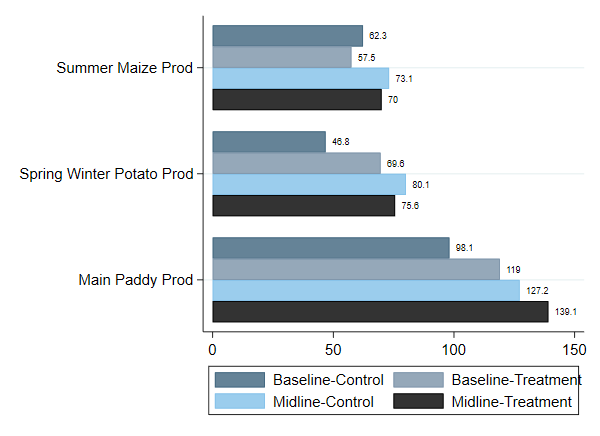



. global stata_kernel_graph_counter = $stata_kernel_graph_counter + 1        


In [10]:
qui forvalues j = 1/3 {
	levelsof crop if _n==`j', local(crop`j')
	}

twoway bar bl_0 xbl_0, horizontal bcolor(edkblue) barwidth(.2) || ///
	bar ml_0 xml_0, horizontal bcolor(eltblue) barwidth(.2) || ///
	scatter xml_0 ml_0, mlabel(ml_0) mlabcolor(black) msymbol(none) mlabsize(vsmall) || ///
	scatter xbl_0 bl_0, mlabel(bl_0) mlabcolor(black) msymbol(none) mlabsize(vsmall) || ///
	bar bl_1 xbl_1, horizontal bcolor(emidblue) barwidth(.2) || ///
	bar ml_1 xml_1, horizontal bcolor(black) barwidth(.2) || ///
	scatter xml_1 ml_1, mlabel(ml_1) mlabcolor(black) msymbol(none) mlabsize(vsmall) || ///
	scatter xbl_1 bl_1, mlabel(bl_1) mlabcolor(black) msymbol(none) mlabsize(vsmall) ///
	xlabel(0 "0" 50 "50" 100 "100" 150 "150") ///
	xscale(range(0(20)100)) /// 
	ylabel(1.3 `crop1' 2.3 `crop2' 3.3 `crop3', angle(0)) ///
	graphregion(color(white)) bgcolor(white) ///
	legend(label(1 "Baseline-Control") label(2 "Midline-Control") label(5 "Baseline-Treatment") label(6 "Midline-Treatment") order(1 5 2 6)) 

### 11. Exporting the graph

In [11]:
graph export "figure.png", replace

(file figure.png written in PNG format)
